___
<a href='https://cafe.naver.com/jmhonglab'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="50%" height="50%"/></p></a>
___
<center><em>Content Copyright by HongLab, Inc.</em></center>

# 확률적 경사하강법(Stochastic Gradient Descent)


### Mini Batch Training

- 데이터의 일부만 넣어서 작은 Batch 단위로 최적화 실행 (주로 GPU 메모리 한계 때문)
- Epoch 단위로 샘플들의 순서를 뒤섞는다.

In [1]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# 데이터셋 컨테이너
class MyDataset(Dataset):
    def __init__(self):
        df = pd.read_csv('diamonds.csv')
        self.x_input = df["carat"].to_numpy(dtype=np.float32)
        self.y_target = df["price"].to_numpy(dtype=np.float32)

    def __len__(self):
        return len(self.x_input)

    def __getitem__(self, idx):
        return (self.x_input[idx], self.y_target[idx])


In [2]:
import torch
import numpy as np
import copy

class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(1))
        self.b = torch.nn.Parameter(torch.randn(1))
    
    def forward(self, x):
        y = self.a * x + self.b
        return y

def regression(dataset, batch_size, model, criterion, optimizer, num_epochs, scheduler = None):

    epoch_loss_history = []
    model_history = []

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    # shuffle은 x_input과 y_target을 함께 섞어준다
    # batch는 전체에서 batch_size개씩 뽑아서 준다.

    for epoch in range(1, num_epochs + 1):

        epoch_loss = 0.0

        for i, (x_input, y_target) in enumerate(data_loader):

            optimizer.zero_grad()
            output = model(x_input)
            loss = criterion(output, y_target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if scheduler:
            scheduler.step()
            

        epoch_loss /= len(data_loader)

        epoch_loss_history.append(epoch_loss)
        model_history.append(copy.deepcopy(model))
        
        if epoch % (num_epochs // 10) == 0:
            message = f"Epoch {epoch}: loss = {epoch_loss}"
            if scheduler:
                message += f", lr = {scheduler.get_last_lr()[0]}"
            print(message)
            

    return epoch_loss_history, model_history

In [3]:
# 그래프로 결과 확인
import matplotlib.pyplot as plt
import math

def visualize(x_input, y_target, loss_history, model_history):

    plt.figure(figsize=(24, 6))

    plt.subplot(141)

    plt.scatter(x_input, y_target, s = 1) # 모든 데이터 샘플 그리기

    # 훈련 마지막 모델의 출력 그리기
    x = np.linspace(x_input.min(), x_input.max(), 10)
    y = model_history[-1](torch.tensor(x)).detach().numpy() 
    plt.plot(x, y, c="red")
    #[참고] tensor.detach().numpy(): 훈련에 필요한 정보들은 빼고 순수 값만 넘파이로 변환

    plt.subplot(142)

    num_steps = len(loss_history) // 10
    plt.scatter(x_input, y_target, s = 1) # 샘플 그리기
    colors = plt.cm.rainbow(np.linspace(0,1,10))
    for i in range(0, len(model_history), num_steps):
        y = model_history[i](torch.tensor(x)).detach().numpy()
        plt.plot(x, y, c=colors[i//num_steps])

    plt.subplot(143)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(loss_history)

    plt.subplot(144)

    plt.xlabel("Epoch")
    plt.ylabel("Log loss")
    plt.plot([math.log(l) for l in loss_history])

    plt.show()



Epoch 40: loss = 2409386.5208333335
Epoch 80: loss = 2407562.684027778
Epoch 120: loss = 2407194.4953703703
Epoch 160: loss = 2407333.6039351854
Epoch 200: loss = 2409773.9417824075
Epoch 240: loss = 2408838.3465277776
Epoch 280: loss = 2409818.061574074
Epoch 320: loss = 2407303.2224537036
Epoch 360: loss = 2410126.78125
Epoch 400: loss = 2404775.979398148


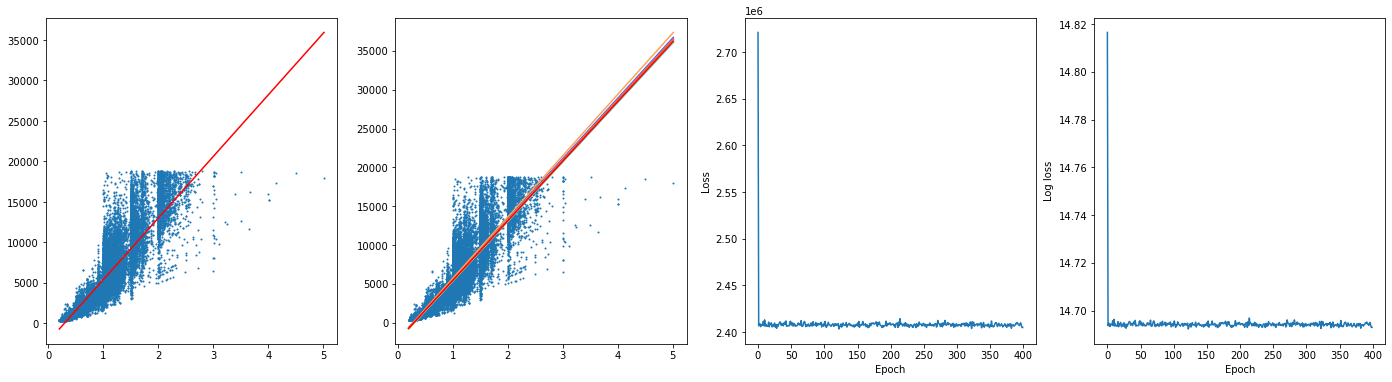

In [4]:
torch.manual_seed(0)

dataset = MyDataset()
model = LinearModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

epoch_loss_history, model_history = regression(dataset, 100, model, criterion, optimizer, 400)

visualize(dataset.x_input, dataset.y_target, epoch_loss_history, model_history)

Epoch 40: loss = 2398536.68599537, lr = 1.3292279957849188e-05
Epoch 80: loss = 2398512.039699074, lr = 1.7668470647783923e-09
Epoch 120: loss = 2399217.4532407406, lr = 2.34854258277385e-13
Epoch 160: loss = 2397191.197800926, lr = 3.1217485503160225e-17
Epoch 200: loss = 2397660.9240740743, lr = 4.1495155688810424e-21
Epoch 240: loss = 2398916.810185185, lr = 5.515652263102062e-25
Epoch 280: loss = 2397606.360532407, lr = 7.331559403129706e-29
Epoch 320: loss = 2396873.704861111, lr = 9.745314011400174e-33
Epoch 360: loss = 2400940.5805555554, lr = 1.2953744211668134e-36
Epoch 400: loss = 2396412.355902778, lr = 1.7218479456386129e-40


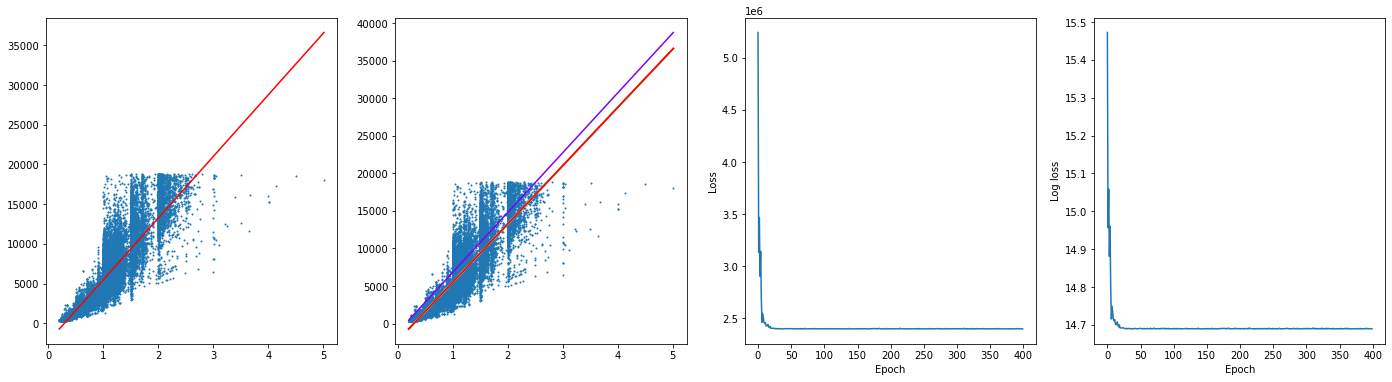

In [5]:
torch.manual_seed(0)

dataset = MyDataset()
model = LinearModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.99)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.8)

epoch_loss_history, model_history = regression(dataset, 100, model, criterion, optimizer, 400, scheduler)

visualize(dataset.x_input, dataset.y_target, epoch_loss_history, model_history)

Epoch 40: loss = 10060299.86388889
Epoch 80: loss = 5805495.797685185
Epoch 120: loss = 3405493.0368055557
Epoch 160: loss = 2531804.5811342592
Epoch 200: loss = 2407064.0287037035
Epoch 240: loss = 2399530.0157407406
Epoch 280: loss = 2397664.527199074
Epoch 320: loss = 2396920.6929398146
Epoch 360: loss = 2400987.987962963
Epoch 400: loss = 2396452.4082175926


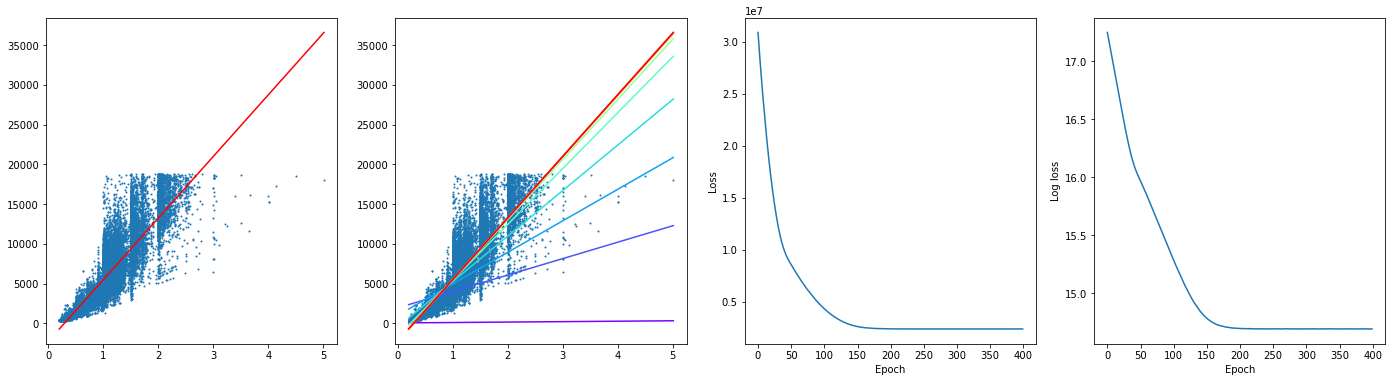

In [6]:
torch.manual_seed(0)

dataset = MyDataset()
model = LinearModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

epoch_loss_history, model_history = regression(dataset, 100, model, criterion, optimizer, 400)

visualize(dataset.x_input, dataset.y_target, epoch_loss_history, model_history)